In [63]:
import numpy as np
import pandas as pd
import sys
import os
import shutil
from sklearn.metrics import silhouette_score

<h2>데이터 전처리<h2>

In [2]:
def read_text_files_to_dataframe(folder_path):
    
    latitude = []
    longitude = []
    date = []
    time = []

    # 폴더 내의 모든 텍스트 파일을 읽음
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            # 텍스트 파일을 DataFrame에 추가

            with open(file_path, 'r') as file:
                data = file.read()

            data = data.split('\n')[6:-1]
            for i in range(len(data)):
                line = data[i].split(',')
                latitude.append(line[0])
                longitude.append(line[1])
                date.append(line[5])
                time.append(line[6])

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    df = df.drop(['date', 'time'], axis=1)
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    return df

In [3]:
folder_path = "C:\\Users\\sk002\\OneDrive\\바탕 화면\\학교\\Yoodori\\Geolife Trajectories 1.3\\Data\\000\\Trajectory"

dataframe = read_text_files_to_dataframe(folder_path)

dataframe

,latitude,longitude,datetime
0,39.984702,116.318417,2008-10-23 02:53:00
1,39.984586,116.316716,2008-10-23 02:54:00
2,39.984485,116.314426,2008-10-23 02:55:00
3,39.984696,116.312921,2008-10-23 02:56:00
4,39.984656,116.310660,2008-10-23 02:57:00
...,...,...,...
15118,39.996230,116.326576,2009-07-05 07:41:00
15119,39.999069,116.328971,2009-07-05 07:42:00
15120,39.999975,116.327367,2009-07-05 07:43:00
15121,39.999974,116.327326,2009-07-05 07:44:00


<h2>의미장소 추출<h2>

In [4]:
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
import folium

In [17]:
def gmeans_(df):
    # 두 열을 선택하고 넘파이 배열로 변환
    selected_columns = ['latitude', 'longitude']
    result_list = df[selected_columns].values.tolist()
    
    gmeans_instance = gmeans(result_list).process()

    # Extract clustering results: clusters and their centers
    clusters = gmeans_instance.get_clusters()
    centers = gmeans_instance.get_centers()

    return clusters, centers
    

In [6]:
def map(centers, i):

    # 예제 데이터 생성 (서울의 위도, 경도)
    locations = centers

    # 지도의 중심 좌표 설정
    map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

    # Folium 맵 생성
    mymap = folium.Map(location=map_center, zoom_start=12)

    # 위치 데이터를 지도에 마커로 표시
    for loc in locations:
        folium.Marker(location=loc, popup='Location').add_to(mymap)

    # 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
    file_name = f'map{i}.html'
    mymap.save(file_name)


In [7]:
def fileReader(folder_path, filename):
    latitude = []
    longitude = []
    date = []
    time = []
    file_path = os.path.join(folder_path, filename)
            
    # 텍스트 파일을 DataFrame에 추가

    with open(file_path, 'r') as file: 
        data = file.read()

    data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])
        longitude.append(line[1])
        date.append(line[5])
        time.append(line[6])

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})

    return df

In [8]:
def app(folder_path):
    
    j = 0
    data_dict = {}
    # 폴더 내의 모든 텍스트 파일을 읽음
    for filename in os.listdir(folder_path):

        df = fileReader(folder_path, filename)

        df['latitude'] = df['latitude'].astype(float)
        df['longitude'] = df['longitude'].astype(float)
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
        df['datetime'] = df['datetime'].dt.floor('T')
        df = df.drop(['date', 'time'], axis=1)
        df = df.drop_duplicates(['datetime'], ignore_index=True)

        clusters, centers = gmeans(df)

        data_dict[j] = pd.DataFrame({"clusters":clusters, "centers":centers})
        
        for k in range(len(data_dict[j].clusters)):
            if (len(data_dict[j].clusters[k]) < 6):
                data_dict[j].drop(index=k, inplace=True)
        data_dict[j] = data_dict[j].sort_index(axis=1)

        map(centers, j)
        
        j += 1
    return data_dict

In [9]:
#folder_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\000\Trajectory'
#data_dict = app(folder_name)

In [18]:
def fileReader(filename):

    latitude = []   # 위도
    longitude = []  # 경도
    date = []       # 날짜
    time = []       # 시간

    with open(filename, 'r') as file:
        data = file.read()

    # 데이터에 불필요한 부분 제거
    # 추후 데이터 형식에 따라 수정 필요 *
    data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])    # 위도
        longitude.append(line[1])   # 경도
        date.append(line[5])        # 날짜
        time.append(line[6])        # 시간

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})

    return df

In [19]:
def gmeansFit(df):
    # 두 열을 선택하고 넘파이 배열로 변환
    selectedColumns = ['latitude', 'longitude']
    resultList = df[selectedColumns].values.tolist()    # 리스트로 변환
    
    gmeansInstance = gmeans(resultList).process()       # 클러스터링

    centers = gmeansInstance.get_centers()              # 클러스터의 중심 (의미장소)
    clusters = gmeansInstance.get_clusters()            # 분류된 클러스터


    return clusters, centers

In [20]:
def gmeansFunc(file_name):
    
    j = 0
    data_dict = {}

    df = fileReader(file_name)

    # 위도 경도 데이터 형식 변경
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    # 날짜, 시간 데이터 병합
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    df = df.drop(['date', 'time'], axis=1)
    # 1분 단위로 데이터 병합
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    # 의미장소 추출
    clusters, centers = gmeansFit(df)
        
    # 딕셔너리 형식으로 데이터 저장
    data_dict[j] = pd.DataFrame({"clusters":clusters, "centers":centers})
        
    # 클러스터가 10개 미만인 의미장소 제거
    for k in range(len(data_dict[j].clusters)):
        if (len(data_dict[j].clusters[k]) < 10):
            data_dict[j].drop(index=k, inplace=True)
    data_dict[j] = data_dict[j].sort_index(axis=1)
        
    j += 1
    return data_dict

In [21]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\000\Trajectory\20090403011657.txt'
data_dict = gmeansFunc(file_name)

TypeError: list indices must be integers or slices, not list

<h2>서버에 올릴 코드<h2>

In [1]:
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
import numpy as np
import pandas as pd
import os
import folium

In [19]:
def fileReader(filename):

    latitude = []   # 위도
    longitude = []  # 경도
    date = []       # 날짜
    time = []       # 시간

    with open(filename, 'r') as file:
        data = file.read()

    # 데이터에 불필요한 부분 제거
    # 추후 데이터 형식에 따라 수정 필요 *
    data = data.split('\n')[6:-1]
    for i in range(len(data)):
        line = data[i].split(',')
        latitude.append(line[0])    # 위도
        longitude.append(line[1])   # 경도
        date.append(line[5])        # 날짜
        time.append(line[6])        # 시간

    df = pd.DataFrame({"latitude":latitude, "longitude":longitude, "date":date, "time":time})

    
    df['latitude'] = df['latitude'].astype(float)
    df['longitude'] = df['longitude'].astype(float)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S')
    df['datetime'] = df['datetime'].dt.floor('T')
    df = df.drop(['date', 'time'], axis=1)
    df = df.drop_duplicates(['datetime'], ignore_index=True)

    return df

In [3]:
# 의미장소 추출
def gmeansFit(df):
    # 두 열을 선택하고 넘파이 배열로 변환
    selectedColumns = ['latitude', 'longitude']
    resultList = df[selectedColumns].values.tolist()    # 리스트로 변환
    
    gmeansInstance = gmeans(resultList).process()       # 클러스터링

    centers = gmeansInstance.get_centers()              # 클러스터의 중심 (의미장소)
    clusters = gmeansInstance.get_clusters()            # 분류된 클러스터


    return clusters, centers

In [20]:
def gmeansFunc(df):
    
    j = 0

    clusters, centers = gmeansFit(df)

    data_df = pd.DataFrame({"clusters":clusters, "centers":centers})
        
    for k in range(len(data_df.clusters)):
        if (len(data_df.clusters[k]) < 10):
            data_df.drop(index=k, inplace=True)
    data_df = data_df.sort_index(axis=1)
    data_df = data_df.reset_index(drop=True)

    # map(centers, j)

        
    j += 1
    return data_df

In [21]:
file_name = r'C:\Users\sk002\OneDrive\바탕 화면\학교\Yoodori\Geolife Trajectories 1.3\Data\000\Trajectory\20090403011657.txt'
df = fileReader(file_name)
data_df = gmeansFunc(df)

In [24]:
data_df

,centers,clusters
0,"[39.9097909090909, 116.40469272727273]","[1037, 1038, 1039, 1040, 1041, 1042, 1043, 104..."
1,"[39.89846146153847, 116.38943146153848]","[1075, 1076, 1077, 1078, 1079, 1080, 1081, 108..."
2,"[39.98576385, 116.41272174999999]","[89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 1..."
3,"[40.009614027027034, 116.31523137837836]","[39, 41, 42, 50, 223, 224, 231, 245, 348, 349,..."
4,"[40.00951454999999, 116.31530625]","[40, 228, 229, 376, 426, 433, 443, 450, 482, 5..."
5,"[40.0098346451613, 116.31509264516127]","[47, 242, 248, 250, 387, 415, 455, 462, 567, 5..."
6,"[40.00973762499999, 116.31511082499999]","[247, 317, 341, 382, 398, 428, 456, 509, 530, ..."
7,"[40.00993477272727, 116.3152046818182]","[38, 45, 46, 309, 330, 342, 370, 413, 534, 692..."
8,"[40.00968824242424, 116.31517781818182]","[244, 249, 316, 319, 325, 327, 329, 422, 423, ..."
9,"[40.00976213157895, 116.31521149999999]","[318, 337, 350, 351, 352, 353, 354, 355, 356, ..."


In [26]:
df

,latitude,longitude,datetime
0,40.001520,116.311859,2009-04-03 01:16:00
1,40.001437,116.312250,2009-04-03 01:17:00
2,40.002051,116.312630,2009-04-03 01:18:00
3,40.004016,116.312476,2009-04-03 01:19:00
4,40.004578,116.314774,2009-04-03 01:20:00
...,...,...,...
1166,40.009642,116.315100,2009-04-04 14:31:00
1167,40.009683,116.315028,2009-04-04 14:32:00
1168,40.009551,116.315061,2009-04-04 14:33:00
1169,40.009591,116.315148,2009-04-04 14:34:00


In [29]:
df.iloc[1037]

latitude                 39.9098
longitude             116.404888
datetime     2009-04-04 12:04:00
Name: 1037, dtype: object

In [28]:
data_df.clusters.iloc[0][0]

1037

In [44]:
data_df

,centers,clusters
0,"[39.9097909090909, 116.40469272727273]","[1037, 1038, 1039, 1040, 1041, 1042, 1043, 104..."
1,"[39.89846146153847, 116.38943146153848]","[1075, 1076, 1077, 1078, 1079, 1080, 1081, 108..."
2,"[39.98576385, 116.41272174999999]","[89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 1..."
3,"[40.009614027027034, 116.31523137837836]","[39, 41, 42, 50, 223, 224, 231, 245, 348, 349,..."
4,"[40.00951454999999, 116.31530625]","[40, 228, 229, 376, 426, 433, 443, 450, 482, 5..."
5,"[40.0098346451613, 116.31509264516127]","[47, 242, 248, 250, 387, 415, 455, 462, 567, 5..."
6,"[40.00973762499999, 116.31511082499999]","[247, 317, 341, 382, 398, 428, 456, 509, 530, ..."
7,"[40.00993477272727, 116.3152046818182]","[38, 45, 46, 309, 330, 342, 370, 413, 534, 692..."
8,"[40.00968824242424, 116.31517781818182]","[244, 249, 316, 319, 325, 327, 329, 422, 423, ..."
9,"[40.00976213157895, 116.31521149999999]","[318, 337, 350, 351, 352, 353, 354, 355, 356, ..."


In [50]:
df['latitude'].iloc[1038]

39.909722

In [54]:
df['latitude'].iloc[0]

40.00152

In [58]:
cluster_index_mapping = {}  # 클러스터의 인덱스 매핑을 저장할 딕셔너리
df['labels'] = 0
for cluster_idx, (cluster, center) in enumerate(zip(data_df.clusters, data_df.centers)):
    for point_idx in cluster:
        df['labels'].iloc[point_idx] = cluster_idx
        # cluster_index_mapping[point_idx] = {'cluster_number': cluster_idx,
        #                                     'latitude' : df['latitude'].iloc[point_idx],
        #                                       'longitude' : df['longitude'].iloc[point_idx]}

df

C:\Users\sk002\AppData\Local\Temp\ipykernel_7760\3375516688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_7760\3375516688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'].iloc[point_idx] = cluster_idx
C:\Users\sk002\AppData\Local\Temp\ipykernel_7760\3375516688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'].iloc

,latitude,longitude,datetime,labels
0,40.001520,116.311859,2009-04-03 01:16:00,0
1,40.001437,116.312250,2009-04-03 01:17:00,0
2,40.002051,116.312630,2009-04-03 01:18:00,0
3,40.004016,116.312476,2009-04-03 01:19:00,0
4,40.004578,116.314774,2009-04-03 01:20:00,0
...,...,...,...,...
1166,40.009642,116.315100,2009-04-04 14:31:00,14
1167,40.009683,116.315028,2009-04-04 14:32:00,19
1168,40.009551,116.315061,2009-04-04 14:33:00,12
1169,40.009591,116.315148,2009-04-04 14:34:00,13


In [8]:
import folium

# 예제 데이터 생성 (서울의 위도, 경도)
locations = data_df.centers.values.tolist()

# 지도의 중심 좌표 설정
map_center = [sum(x[0] for x in locations) / len(locations), sum(x[1] for x in locations) / len(locations)]

# Folium 맵 생성
mymap = folium.Map(location=map_center, zoom_start=12)

# 위치 데이터를 지도에 마커로 표시
for loc in locations:
    folium.Marker(location=loc, popup='Location').add_to(mymap)

# 지도를 HTML 파일로 저장하거나 주피터 노트북에서 바로 표시
mymap


<h2>실루엣 계수<h2>

In [61]:
df.iloc[1038]

latitude               39.909722
longitude             116.404901
datetime     2009-04-04 12:05:00
labels                         0
Name: 1038, dtype: object

In [65]:
silhouette_avg = silhouette_score(df[['latitude', 'longitude']], df['labels'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.0066578087266783775


<h2>T-SNE 시각화<h2>

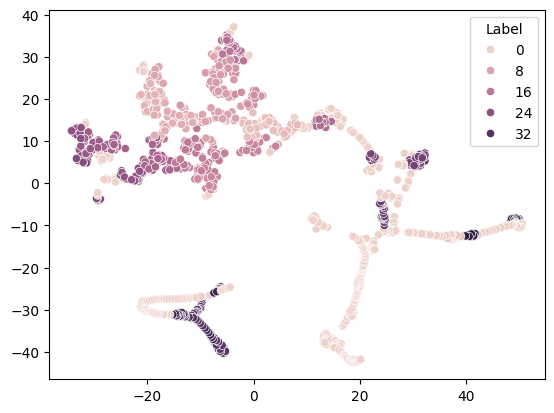

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 X와 레이블 y를 사용한다고 가정
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df[['latitude', 'longitude']])

sns.set_palette("deep")
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=df['labels'])
plt.legend(title='Label')
plt.show()
